# Aufgabe für die Projektgruppe 4

Bearbeiten Sie die folgende Aufgabe:

Ihr Auftraggeber ist eine Familie, welche eine Beratung von Ihnen benötigt. Sie besitzt ein kleines altes Windrad, welches nur für den Eigenverbrauch genutzt wird sowie eine PV Anlage. Die Familie möchte von Ihnen wissen, ob Sie Kosten durch die Investition in verschiedene Komponenten ihres Energiesystems einsparen kann. 

Nehmen Sie dabei die folgenden Angaben an:
* Nennleistung der Windernergieanlage: 5 kW (Keine EEG- Vergütung)
* Nennleistung der PV-Anlage 9 kWp (70% Kappungsgrenze berücksichtigen)
* Die Anschlussleistung an das elektrische Netz beträgt 15 kW
* Die Heizleistung des Erdgaskessel liegt bei 20 kW, der Wirkungsgrad ist 99%
* Erdgaspreis: 7 cent/kWh
* Strompreis: 30 cent/kWh
* EEG-Vergütung PV Anlage: 12,30 cent/kWh

Prüfen und kombinieren Sie mindestens drei der unten aufgeführten Optionen und bewerten Sie diese nach ihrer wirtschaftlicher Vorteilhaftigkeit. Unter den gewählten Optionen sollte sich mindestens eine der beiden Optionen BHKW oder Wärmepumpe befinden:
- Implementierung eines Heizstabes mit annuitätische Kosten von 50€ (Elektrische Leistung 5 kW, Wirkungsgrad 98%) 
- Installation eines BHKWs mit annuitätische Kosten von 1.200€ (Elektrische Leistung 1kW, elektrischer Wirkungsgrad 16%, Thermischer Wirkungsgrad 80%, nehmen Sie eine feste Stromkennzahl von 0,2 an, ein Beispiel für die Implementierung eines BHKWs in PyPSA finden Sie hier: https://pypsa.org/examples/chp-fixed-heat-power-ratio.html. Eine KWK-Vergütung müssen Sie nicht implementieren, da hier die pauschalierte Zuschlagzahlung gewählt wird.)
- Beschaffung einer elektrischen Batterie mit annuitätische Kosten von 900€ (8kWh Kapazität, 2,4 kW Speicher und Ladeleistung, einem Gesamtwirkungsgrad von 85%, keine Selbstentladungsverluste) 
- Erweiterung des Heizungssystems um einen thermischen Speicher mit annuitätische Kosten von 100€ (7kWh Kapazität und eine Ein und Ausspeicherleistung von 12 kW, keine Selbstentladungsverluste)
- Implementierung einer selbst gewählten Wärmepumpe. Hier müssen Sie nach geeigneten Daten zu Leistungen, Kosten und Performance recherchieren. Sie dürfen dabei die Jahresarbeitszahl als konstanten COP annehmen. Gehen Sie weiter davon aus, dass der Annuitätenfaktor für eine solche Investition bei 0,117 liegt.

1) Formulieren Sie die Optimierungsaufgabe
2) Skizzieren Sie das heutige System und bestimmen Sie die Kosten.
3) Skizzieren Sie mögliche Erweiterungen und bestimmen Sie die Kosten.
4) Interpretieren Sie die ihre Ergebnisse und ziehen Sie Schlussfolgerungen.
5) Bestimmen Sie die Grenzen Ihrer Modellierung und begründen Sie, ob die Ergebnisse trotz der Beschränkungen valide sind.

Der Import der Lastzeitreihen und der Einspeisezeitreihen ist unten schon vorbereitet. Diese repräsentieren das Jahr 2018 in stündlicher Auflösung. Nutzen Sie das in der Übung besprochene JupyterNotebook und schauen Sie sich die Funktionen und den Code dort an, um Ihr Energiesystem aufzubauen, es zu simulieren und auszuwerten.  

# Import <a class="anchor" id="chapter1"></a>

## Import der benötigten Python Module <a class="anchor" id="section_1_1"></a>

In [ ]:
import pypsa
import pandas as pd
import math
import numpy as np

## Import der Daten <a class="anchor" id="section_1_2"></a>

Die Werte der Zeitreihen sind in einem Unterordner "data" als csv-Datein abgelegt. Sie bilden das Jahr 2019 ab und werden mithilfe des Python Moduls pandas eingelesen und als Variablen angelegt. Dabei werden Parameter wie der Separator (hier ";") und die Indexspalte sowie die Funktion, aus der Indexspalte Zeit und Datenformate auszulesen gesetzt.

In [40]:
pv_infeed = pd.read_csv('./data/pv_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)
wind_infeed = pd.read_csv('./data/wind_infeed.csv', sep = ',', skiprows =3, index_col='time', parse_dates=True)

In [41]:
electrical_load = pd.read_csv('./data/SumProfiles_3600s.Electricity.csv', sep = ';', index_col='time', parse_dates=True)
thermal_load = pd.read_csv('./data/SumProfiles_3600s.Gas.csv', sep = ';', index_col='time', parse_dates=True)


Die eingelesenen Zeitreihen sind so noch nicht vollständig nutzbar. Um die Einspeisung der Wind und PV-Anlage zu normieren wird eine neue Spalte mit dem normierten Leistungsoutput sowie neue Spalten mit der Leistung der Last in den jeweiligen Variablen angelegt.

In [42]:
#Die gemessene PV-Einspeiseganglinie ist von einer Anlage mit einer Leistung von 9 kWp, die der Windenergieanlage mit 5 kW.
pv_infeed['p_max_pu'] = pv_infeed.electricity/9 
wind_infeed['p_max_pu'] = wind_infeed.electricity/5 

Um einen kurzen Einblick in die Daten zu erhalten, schauen wir uns alle vier Tabellen an:

# Darstellung der thermischen und elektrischen Last, sowie der PV und Wind Einspeisung für das Jahr 2018

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

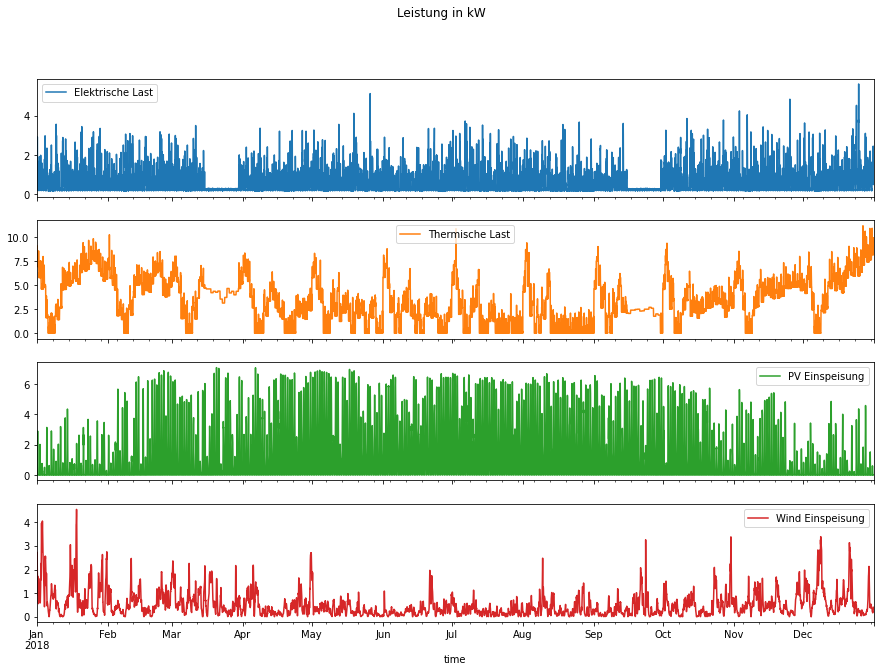

In [43]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

# Darstellung der thermischen und elektrischen Last, sowie der PV und Wind Einspeisung für den Monat Januar im Jahr 2018

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

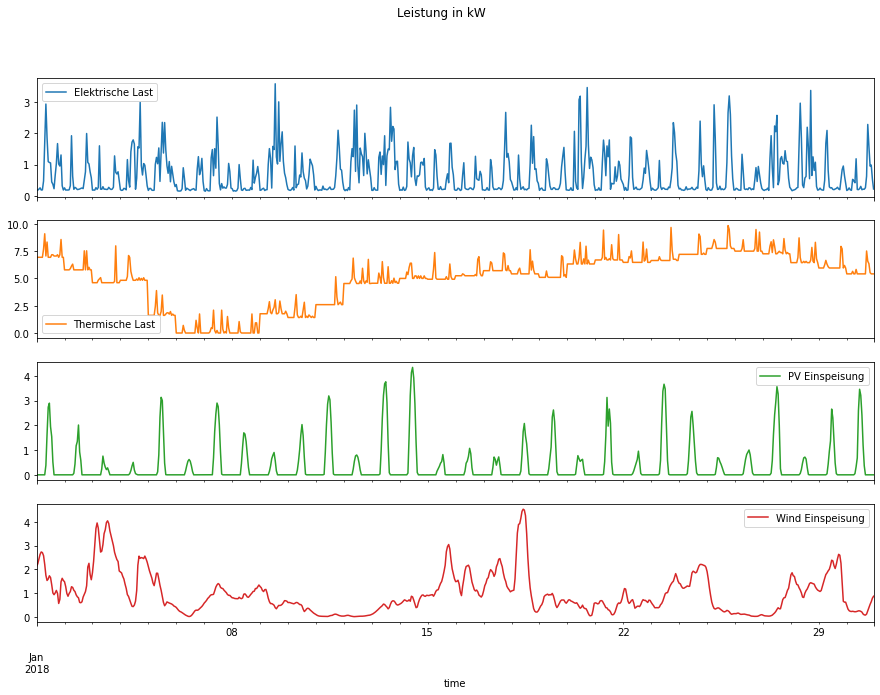

In [44]:
df_figure = pd.concat([electrical_load.sum_kwh, thermal_load.sum_kwh, pv_infeed.electricity,wind_infeed.electricity], axis = 1)
df_figure.columns = ['Elektrische Last', 'Thermische Last', 'PV Einspeisung', 'Wind Einspeisung']
df_figure.loc['01-01-18 00:00:00':'01-30-18 23:00:00'].plot(subplots = True, figsize=(15,10), title= 'Leistung in kW')

# 1) Formulierung der Optimierungsaufgabe

Minimierung der gesamten Heiz- und Stromkosten durch eine sinnvolle Erweiterung des aktuellen Energiesystems anhand von Investitionen in ausgewählte Komponenten (Wärmepumpe, thermischer Speicher, elektrischer Speicher). Maximierung des Eigenverbrauchs = minimierung der Kosten.  

Wärmepumpe in Kombination mit einem thermischen Speicher = Speicherung thermischer Energie und somit auch die Nutzung erzeugter thermischer Energie ist auch möglich, wenn diese zum Erzeugerzeitpunkt nicht benötigt/ genutzt wird. 

Elektrische Batteriespeicher in Kombination mit der Windenergieanlage und einer PV-Anlage = Speicherung der elektrischen Energie und somit auch die Nutzung dieser ist auch möglich, wenn diese zum Erzeugerzeitpunkt nicht benötigt genutzt wird. Besonders sinnvoll in Kombination mit der PV-Anlage, da der Stromverbrauch nicht mit der Stromerzeugung korreliert. So kann der erzeugte PV-Strom auch Abends genutzt werden, wenn er benötigt wird. Da die EEG-Vergütung 12,3 Cent/kWh beträgt und der Netzbezogene Strom 30 cent/kWh kostet = Eigenverbrauch maximieren. 

Der erzeugte Strom aus der Windanlage kann nur genutzt werden, wenn Strom benötigt wird, da eine Einspeisung ins Netz und damit einhergehende Vergütung nicht vorhergesehen ist. Wird kein Strom benötigt ist die Anlage aktuell ohne Nutzen. Deswegen ist auch hier ein Batterieelektrischer Speicher eine sinnvolle Erweiterung. 

# 2) Aktuelles System

# 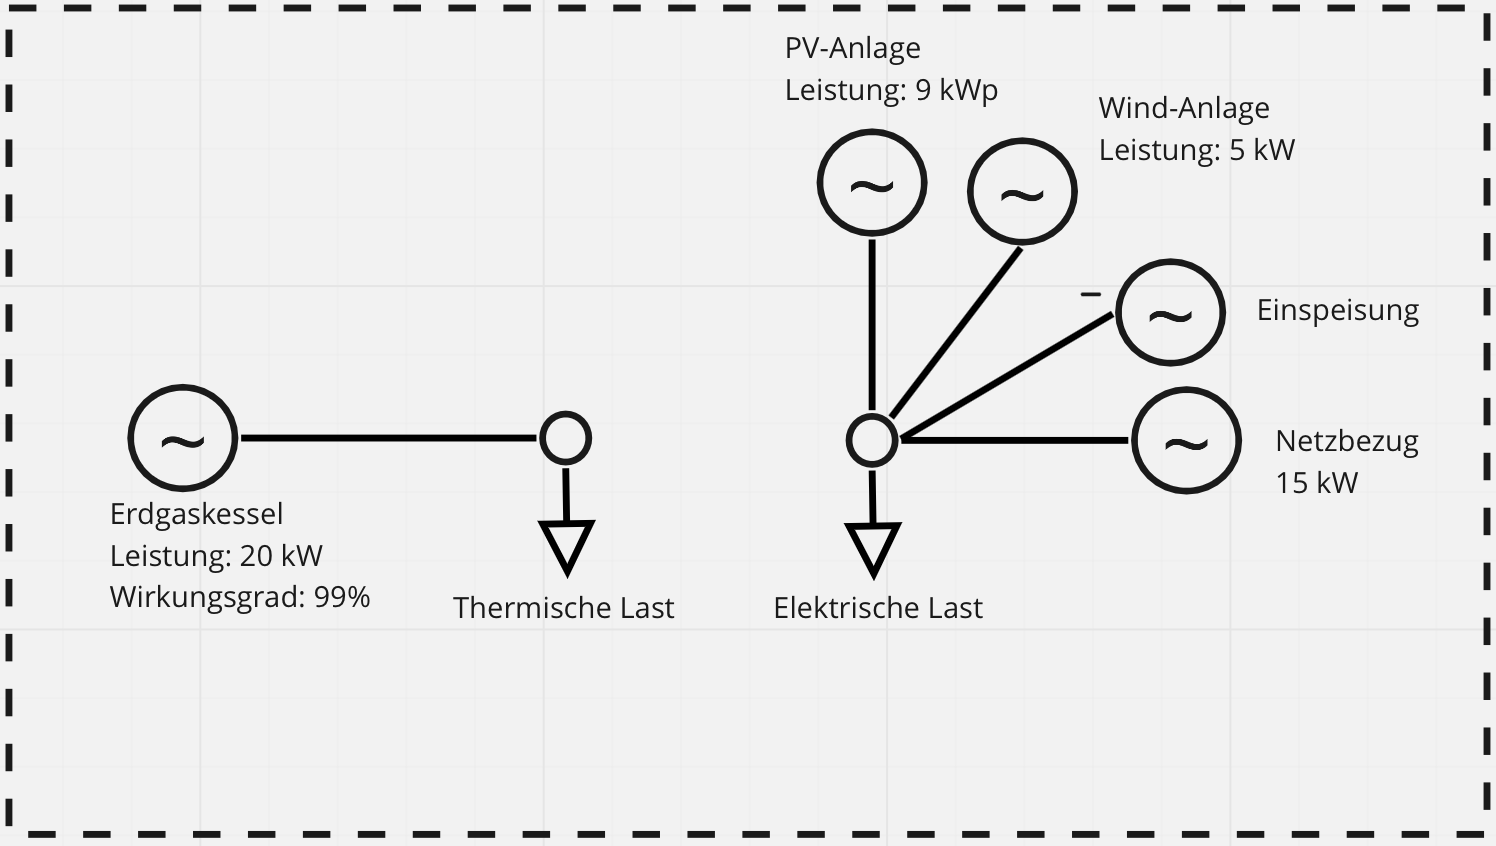

# 3) Modellbildung

### Komponenten des Haushaltes

In [45]:
# Windkraft-Anlage
wind = {"electrical_power": 5.0}

# PV-Anlage
pv = {"electrical_power": 9.0}

#Erdgaskessel
heating_boiler = {"thermal_power": 20.0,
                   "efficiency":0.99,# Effizienz als normierte Kennzahl
                   "gas_costs": 7.0} #Kosten in cent/kWh
                       

### Netzanschluss

In [46]:
# Leistungsbezug aus dem Netz
grid_import = {"electrical_power" : 15.0,
                "electricity_price": 30.0} # Anschlussleisting Netzbezug = 15 kW

#Leistungsabgabe in das Netz
grid_export = {"electrical_power" : 0.7 * pv["electrical_power"], # Kappungsgrenze PV = 70% 
                "electricity_revenue": 12.3} # EEG-Erlöse = 12,30 cent/kWh



### Definition des Netzwerks

In [47]:
#Netzwerk definieren
network = pypsa.Network()
network.set_snapshots(pv_infeed.index)
network.snapshot_weightings = pd.Series(data = 1/1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also (1/1)Stunde.

### Knoten definieren

In [48]:
#Stromknoten definieren
network.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network.add("Bus", 
            name = "thermal")

### Lasten definieren

In [49]:
#Zur Definierung der Last wird die Leistung benötigt. Daher werden die Daten in kW umgerechnet (umbenannt), indem durch eine Stunde geteilt wird
electrical_load['power_kw'] = electrical_load.sum_kwh / 1
thermal_load['power_kw'] = thermal_load.sum_kwh / 1

# Elektrische Last
network.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw) #power_kw in sum.kwh

# Thermische last
network.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)

### Erzeugungseinheiten definieren

In [50]:
#PV-Anlage
network.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Windkraft-Anlage
network.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])

### Netzanschluss definieren

In [51]:
#Netzbezug
network.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

## Simulation

In [52]:
# Simulation der Basiskonfiguration für den kompletten Zeitraum:
network.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.68s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

### Auswertung 

In [53]:
#Auswertung der Kosten und Anteile
def cost_share_evaluation(network):
    '''
    This function evaluate the solved PyPSA network to get the costs, revenues and the share of the selfconsumption.
    
    Parameters
    ----------
    network:            PyPSA Network
                        The solved PyPSA network with all corresponding devices
    Returns
    -------
    results :           dict
                        The dictionary with all the results.
    '''
    
    grid_import = (network.generators_t.p['grid_import'] * network.snapshot_weightings).sum()
    grid_export = (network.generators_t.p['grid_export'] * network.snapshot_weightings).sum()
    self_consumed_pv = (network.generators_t.p['pv'] * network.snapshot_weightings).sum()- grid_export
    self_consumed_wind = (network.generators_t.p['wind'] * network.snapshot_weightings).sum() # wind ergänzen ohne grid_export (kein Verkauf)
    self_consumption_ratio = (self_consumed_pv + self_consumed_wind)/(grid_import + self_consumed_pv + self_consumed_wind) # Wind ergänzen
    
    
    electricity_cost = grid_import * network.generators.marginal_cost['grid_import']
    electricty_revenues = grid_export * network.generators.marginal_cost['grid_export']
    gas_costs = (network.generators_t.p['boiler']*network.snapshot_weightings).sum() * network.generators.marginal_cost['boiler']
    
    curtailment = ((network.generators_t.p_max_pu['pv']*network.generators.p_nom['pv'] - network.generators_t.p['pv'])*network.snapshot_weightings).sum()

    results = {"Eigenverbrauchsanteil": self_consumption_ratio,
              "Stromkosten": electricity_cost,
              "Gaskosten": gas_costs,
              "Stromerlöse": -electricty_revenues,
              "Gesamtkosten": electricity_cost + gas_costs + electricty_revenues,
              "Nicht nutzbare Energie": curtailment}
    results_energy = {'Abregelung': curtailment,
                      'Netzeinspeisung': grid_export,
                      'Eigenverbrauch': self_consumed_pv,
                      'Netzbezug': -grid_import}
                      
    return results, results_energy


###  Kostenberechnung des Basissystems

In [54]:
results_base, results_energy_base  = cost_share_evaluation(network)

#Die Werte sollen auch als Text ausgegeben werden
print("Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt "
      + str(round(results_base["Eigenverbrauchsanteil"]*100,2))
      +"%. Dabei entstehen Stromkosten  von "
      +str(round(results_base["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_base["Gaskosten"]/100,2))
      +"€, und EEG-Erlöse von "
      +str(round(results_base["Stromerlöse"]/100,2))
      +"€, wobei " +str(round(results_base["Nicht nutzbare Energie"]/100,1))+ "kWh PV-Strom abgeregelt werden muss."
      +" Die Gesamtkosten betragen "+ str(round(results_base["Gesamtkosten"]/100,2)) +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der Basiskonfiguration beträgt 68.98%. Dabei entstehen Stromkosten  von 471.59€, Gaskosten von 1891.83€, und EEG-Erlöse von 1469.02€, wobei 0.1kWh PV-Strom abgeregelt werden muss. Die Gesamtkosten betragen 894.4€.


## Visualisierung - aktuellen Systems für das Jahr 2018

<AxesSubplot:xlabel='time'>

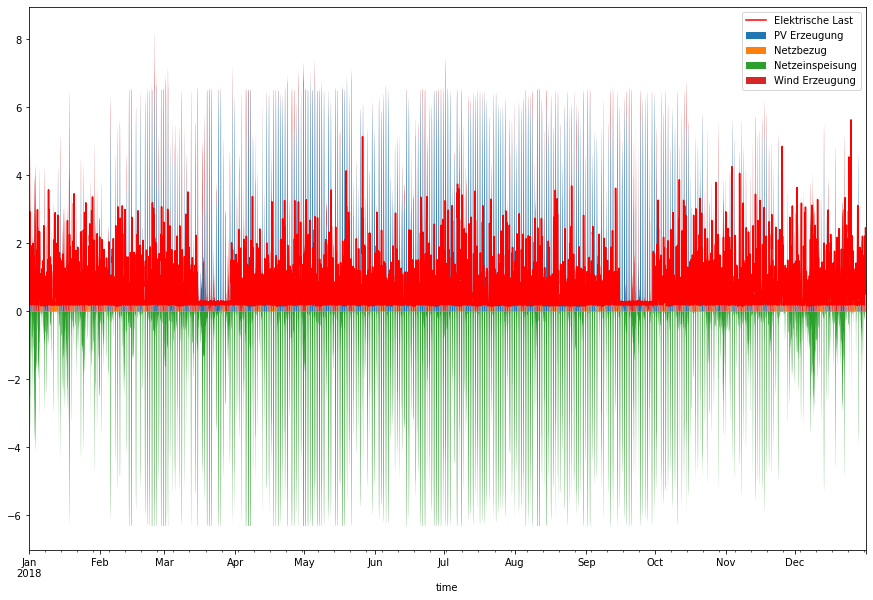

In [55]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(legend = True, color = 'red') #Zeit anpassen Monat-Tag-Jahr !Wie dumm!
df_figure_base = pd.concat([network.generators_t.p['pv'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export'],network.generators_t.p['wind']], axis = 1) # Wind als Graphen mitaufnehmen
df_figure_base.columns = ['PV Erzeugung', 'Netzbezug', 'Netzeinspeisung', 'Wind Erzeugung'] # Wind in der Legende ergänzen
df_figure_base.loc['01-01-18 00:00:00':'12-31-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax) #Zeit anpassen


# Zeiten zum plotten
#01-01-18 00:00:00':'30-12-18 23:00:00 


## Visualisierung - heutiges System für den Moant Januar im Jahr 2018

<AxesSubplot:xlabel='time'>

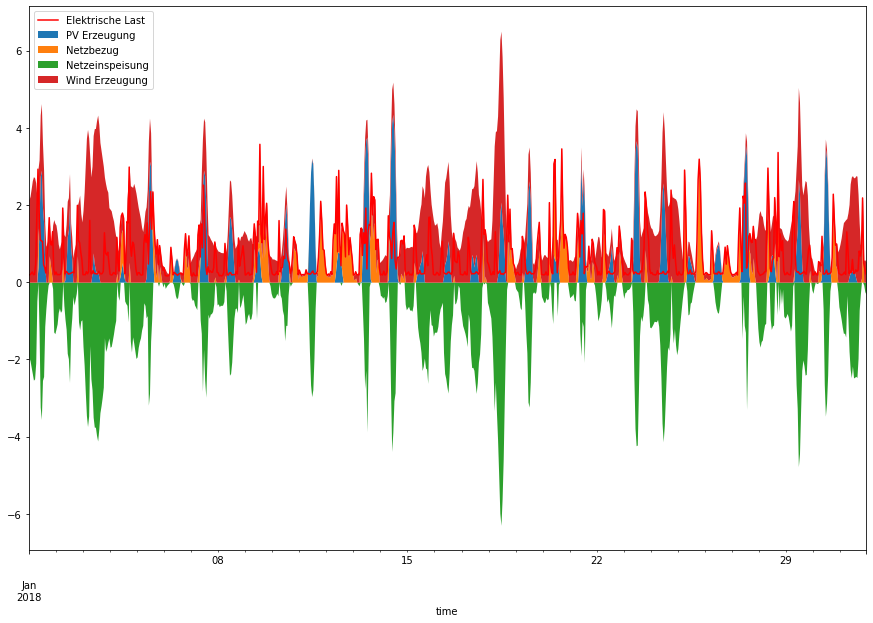

In [56]:
load_figure = network.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'01-31-18 23:00:00'].plot(legend = True, color = 'red') #Zeit anpassen Monat-Tag-Jahr!
df_figure_base = pd.concat([network.generators_t.p['pv'], network.generators_t.p['grid_import'], -network.generators_t.p['grid_export'],network.generators_t.p['wind']], axis = 1) # Wind als Graphen mitaufnehmen
df_figure_base.columns = ['PV Erzeugung', 'Netzbezug', 'Netzeinspeisung', 'Wind Erzeugung'] # Wind in der Legende ergänzen
df_figure_base.loc['01-01-18 00:00:00':'01-31-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax) #Zeit anpassen


# Zeiten zum plotten
#01-01-18 00:00:00':'30-12-18 23:00:00 



# 3) Erweiterungen 

## Basissystem

In [57]:
# Basisnetzwerk implementieren:
network_modified= pypsa.Network()
network_modified.set_snapshots(pv_infeed.index)
network_modified.snapshot_weightings = pd.Series(data = 1/1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.


#Stromknoten definieren
network_modified.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network_modified.add("Bus", 
            name = "thermal")


# Elektrische Last
network_modified.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische last
network_modified.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)


#PV-Anlage
network_modified.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Wind-Anlage
network_modified.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])


#Netzbezug
network_modified.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network_modified.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.



## 3.1) Erweiterung des Basissystems durch elektrischer Batteriespeicher

## Skizze
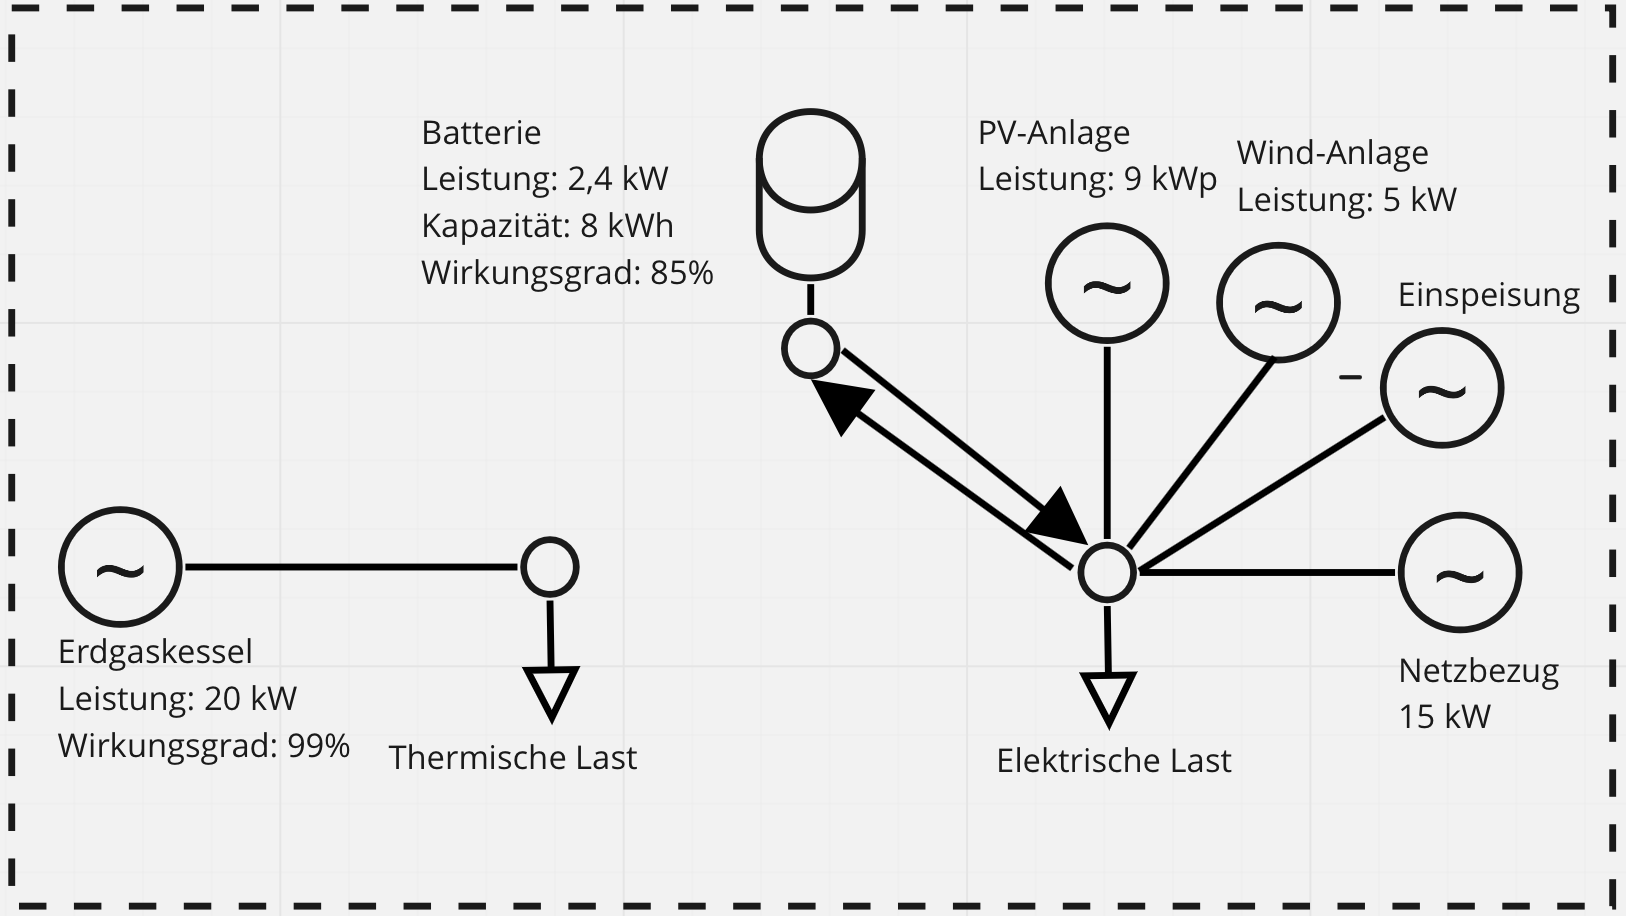

### Elektrischer Speicher - Batterie

In [58]:
# Batteriespeicher
#Basis_Netzwerk_2


# Hilfsknoten
network_modified.add("Bus", 
            name = "storage_electricity")

#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4, # Ladeleistung
            efficiency = math.sqrt(0.85) # Gesamtwirkungsgrad
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4, #Speicherleistung
            efficiency = math.sqrt(0.85)  # Gesamtwirkungsgrad
                    )
#Speicher
network_modified.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8.0, # Kapazität
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            capital_cost = 900) # annuitätische Kosten

### Simulation der Erweiterung mit Batteriespeicher 

In [59]:
# Simulation für den kompletten Zeitraum:
network_modified.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.17s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 6.72e+04


('ok', 'optimal')

### Kosten der Erweiterung mit Batteriespeicher

In [60]:
# Ausführung der Auswertungsfunktion
results_modified, results_energy_modified = cost_share_evaluation(network_modified)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_modified["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_modified["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_modified["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_modified["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified["Gesamtkosten"])/100,2))
      +"€."
      + "Die Stromkosten sinken um knapp 410 €, da der Eigenverbrauch durch den Batteriespeicher deutlich erhöht wird.Durch den Speicher findet eine zeitliche Verschiebung zwischen Erzeugung und Verbrauch statt, sodass auch Abends der selbst produzierte Strom genutzt werden kann, statt vergleichsweise teuren Strom aus den Netz zu beziehen. Die Gesamtkostenersparnis liegt bei 222,76 € im Vergleich zum Basissystem, da hier auch weniger Stromins Netz eingespeist wird und die EEG_erlöse somit sinken.Bei jährlichen Kosten für die Batterie von 900 € und gesparten jährlichen Kosten von kanpp 222€, lohnt der Batteriespeicher sich nicht wirklich, obwohl der Eigenverbrauch signifikant erhöht werden kann. Bei geringeren Kosten oder einer besseren Entladeleistung sowie Speicherleistung würde sich die Batterie wahrscheinlich eher lohnen. "
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 95.81%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 1891.83€ und EEG-Erlöse von 1286.95, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 671.63€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 26.83 Prozentpunkte und eine Verringerung der Kosten um 222.76€.Die Stromkosten sinken um knapp 410 €, da der Eigenverbrauch durch den Batteriespeicher deutlich erhöht wird.Durch den Speicher findet eine zeitliche Verschiebung zwischen Erzeugung und Verbrauch statt, sodass auch Abends der selbst produzierte Strom genutzt werden kann, statt vergleichsweise teuren Strom aus den Netz zu beziehen. Die Gesamtkostenersparnis liegt bei 222,76 € im Vergleich zum Basissystem, da hier auch weniger Stromins Netz eingespeist wird und die EEG_erlöse somit sinken.Bei jährlichen Kosten für die Batterie von 900 € und gesparten jährlichen Kosten von kanp

### Visualisierung mit Erweiterung Batteriespeicher 

<AxesSubplot:xlabel='time'>

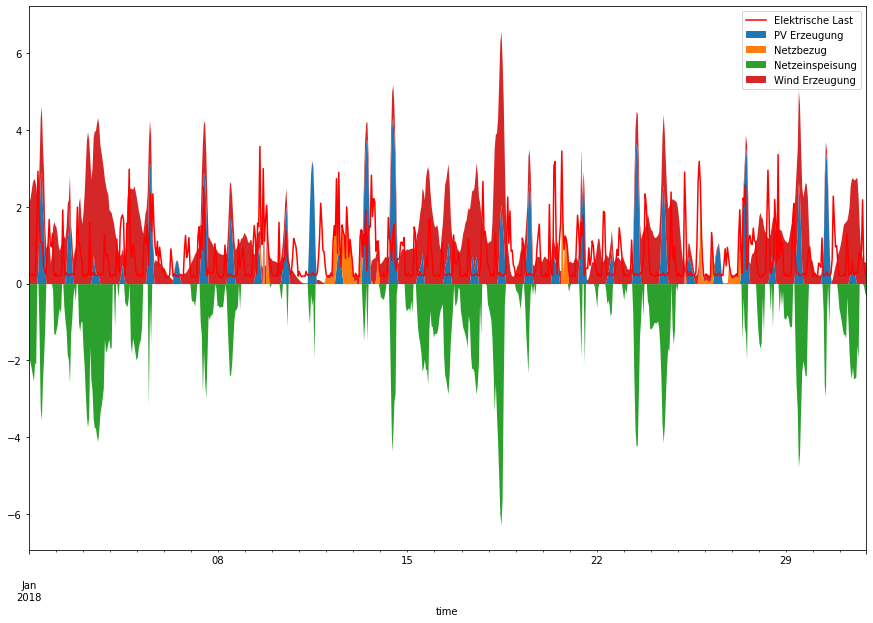

In [61]:
load_figure = network_modified.loads_t.p_set['electricity_load']
load_figure.name = 'Elektrische Last'
ax = load_figure.loc['01-01-18 00:00:00':'01-31-18 23:00:00'].plot(legend = True, color = 'red') #Zeit anpassen Monat-Tag-Jahr!
df_figure_base = pd.concat([network_modified.generators_t.p['pv'], network_modified.generators_t.p['grid_import'], -network_modified.generators_t.p['grid_export'],network_modified.generators_t.p['wind']], axis = 1) # Wind als Graphen mitaufnehmen
df_figure_base.columns = ['PV Erzeugung', 'Netzbezug', 'Netzeinspeisung', 'Wind Erzeugung'] # Wind in der Legende ergänzen
df_figure_base.loc['01-01-18 00:00:00':'01-31-18 23:00:00'].plot(legend =True, subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax=ax) #Zeit anpassen

## 3.2) Erweiterung des Basissystems mit einem thermischen Speicher 


## Skizze
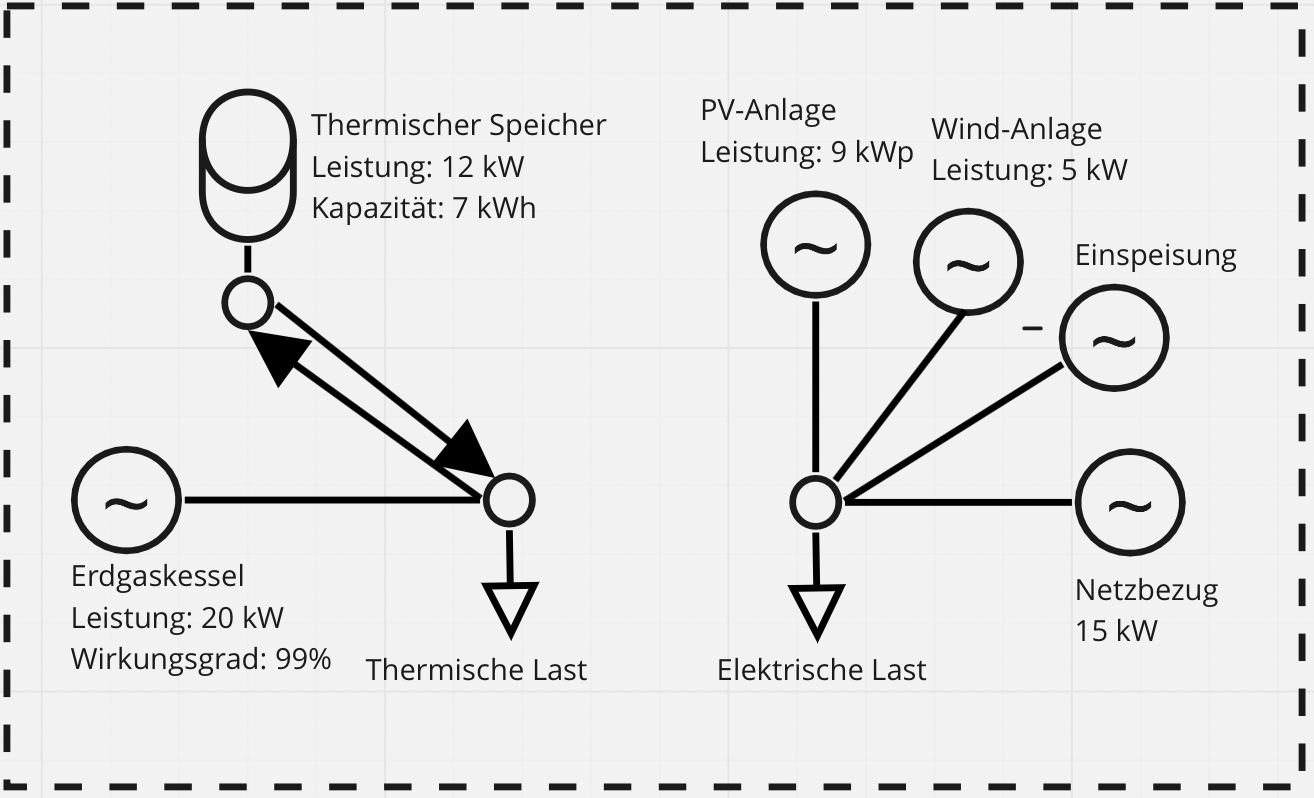


In [62]:
# Basisnetzwerk implementieren modified 2:
network_modified_2= pypsa.Network()
network_modified_2.set_snapshots(pv_infeed.index)
network_modified_2.snapshot_weightings = pd.Series(data = 1/1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.


#Stromknoten definieren
network_modified_2.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network_modified_2.add("Bus", 
            name = "thermal")


# Elektrische Last
network_modified_2.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische last
network_modified_2.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)


#PV-Anlage
network_modified_2.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Wind-Anlage
network_modified_2.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified_2.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])


#Netzbezug
network_modified_2.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network_modified_2.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.


# Hilfsknoten
network_modified_2.add("Bus", 
            name = "storage_thermal")

#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified_2.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12) # 12 kW Einspeicherleistung < Leistung Erdgaskessel

#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified_2.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12) # 12 kW Ausspeicherleistung < Leistung Erdgaskessel

#Speicher
network_modified_2.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7,
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            capital_cost = 100   # annuitätische Kosten
            #keine Selbstentladungsverluste   
            )

### Simulation der Erweiterung mit einem thermischen Speicher 

In [65]:
# Simulation für den kompletten Zeitraum:
network_modified_2.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.92s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 8.94e+04


('ok', 'optimal')

### Kosten des Basissystems mit einem thermischen Speicher als Erweiterung 

In [66]:
# Ausführung der Auswertungsfunktion
results_modified_2, results_energy_modified_2 = cost_share_evaluation(network_modified_2)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified_2["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified_2["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_modified_2["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_modified_2["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_modified_2["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_modified_2["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified_2["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified_2["Gesamtkosten"])/100,2))
      +"€."
      +" Bei einer Erweiterung des Basissystems mit einem thermischen Speicher ändert sich nichts. Da der thermische Speicher nur mit den Heizkesselverbunden ist und es keinen unterschied macht, ob die thermische Last direkt über den Kessel oder eben über den thermischen Speicher abgedeckt wird . Ein Erdgaskessel in Kombination mit einen thermischen Speicher macht keinen Sinn. Diese Kombination ist gar nachteilig, da erzeugte Wärme statt direkt genutzt zu werden, wie es bei Heizkesseln üblich ist, erst mit Verlusten zwischen gespeichert wird.   "
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 68.98%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1891.83€ und EEG-Erlöse von 1469.02, wobei 0.1kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 894.4€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 0.0 Prozentpunkte und eine Verringerung der Kosten um 0.0€. Bei einer Erweiterung des Basissystems mit einem thermischen Speicher ändert sich nichts. Da der thermische Speicher nur mit den Heizkesselverbunden ist und es keinen unterschied macht, ob die thermische Last direkt über den Kessel oder eben über den thermischen Speicher abgedeckt wird . Ein Erdgaskessel in Kombination mit einen thermischen Speicher macht keinen Sinn. Diese Kombination ist gar nachteilig, da erzeugte Wärme statt direkt genutzt zu werden, wie es bei Heizkesseln üblich ist, erst mit Verlusten zwischen gespeichert wird.   


## 3.3) Erweiterung der Basiskonfiguration mit einer Wärmepumpe 

## Skizze
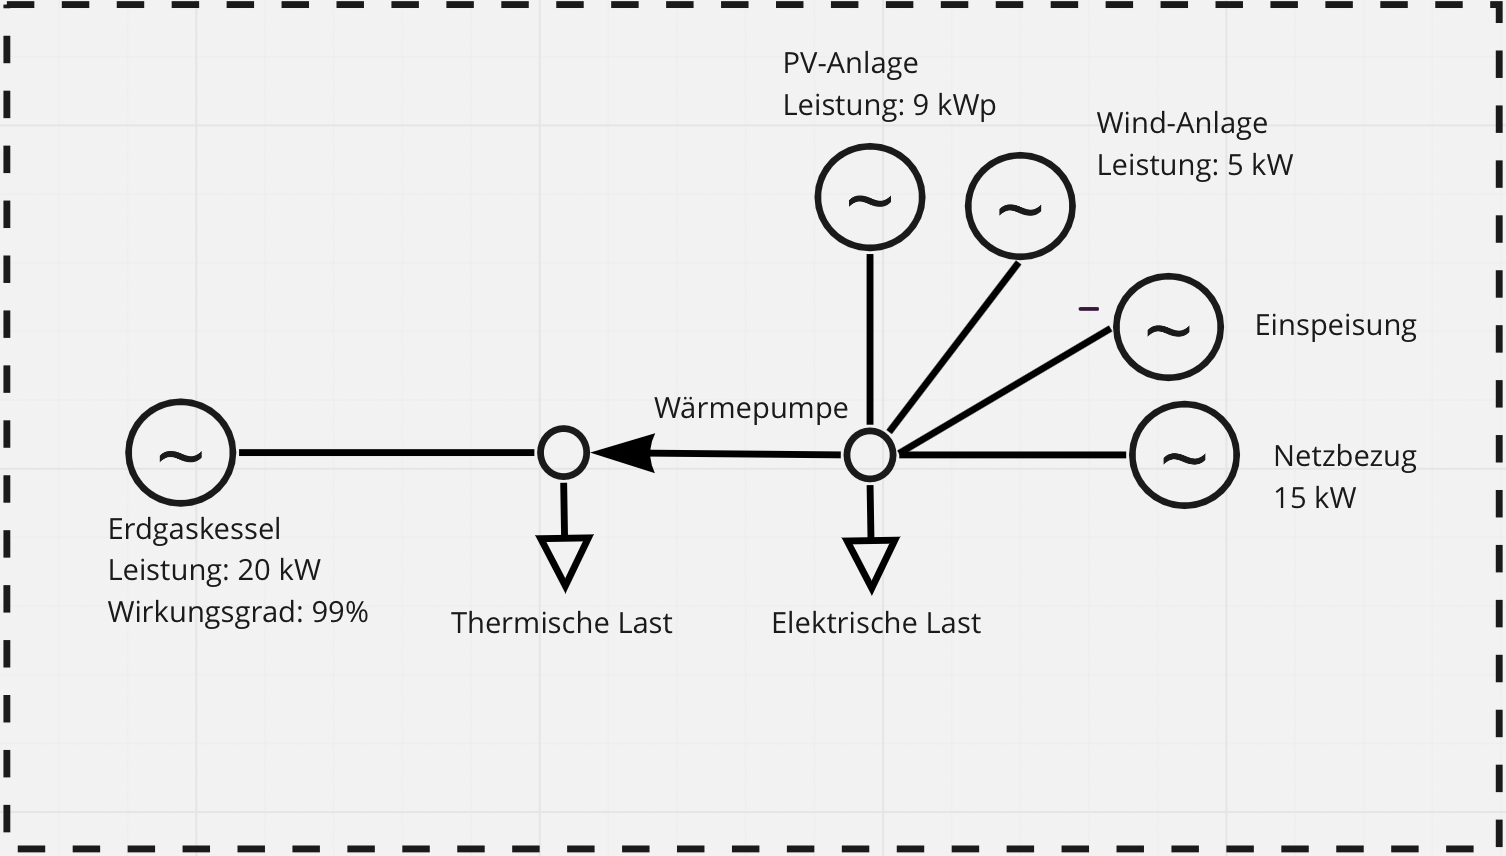

###  Wärmepumpe

In [ ]:
# Basisnetzwerk implementieren modified 3
network_modified_3 = pypsa.Network()
network_modified_3.set_snapshots(pv_infeed.index)
network_modified_3.snapshot_weightings = pd.Series(data = 1/1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.

#Stromknoten definieren
network_modified_3.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network_modified_3.add("Bus", 
            name = "thermal")


# Elektrische Last
network_modified_3.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische last
network_modified_3.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)


#PV-Anlage
network_modified_3.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Wind-Anlage
network_modified_3.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified_3.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])


#Netzbezug
network_modified_3.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network_modified_3.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

#Wärmepumpe
#Hier können Sie die Aufgabe mit der Wärmepumpe implementieren. Geben Sie ihrer Wärmepumpe den namen "heat_pump"
network_modified_3.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=5.5,
            efficiency = 3.2,
            capital_cost = 7374*0.117  
           )

#Quelle: https://www.preis.de/produkte/Dimplex-LA-9S-TUR/4709891.html


## Simulation des Basissystems mit Wärmepumpe als Erweiterung

In [70]:
# Simulation für den kompletten Zeitraum:
network_modified_3.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 0.73s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 5.17e+04


('ok', 'optimal')

## Kosten der Erweiterung

In [72]:
# Ausführung der Auswertungsfunktion
results_with_modification, results_energy_with_modification = cost_share_evaluation(network_modified_3)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_with_modification["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_with_modification["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_with_modification["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_with_modification["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_with_modification["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_with_modification["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_with_modification["Gesamtkosten"])/100,2))
      +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 81.49%.
 Dabei entstehen Stromkosten von 471.59€, Gaskosten von 1102.45€ und EEG-Erlöse von 1056.68, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 517.36€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 12.51 Prozentpunkte und eine Verringerung der Kosten um 377.04€.


## Visualisierung des Basissystems mit einer Wärmepumpe

<AxesSubplot:xlabel='time'>

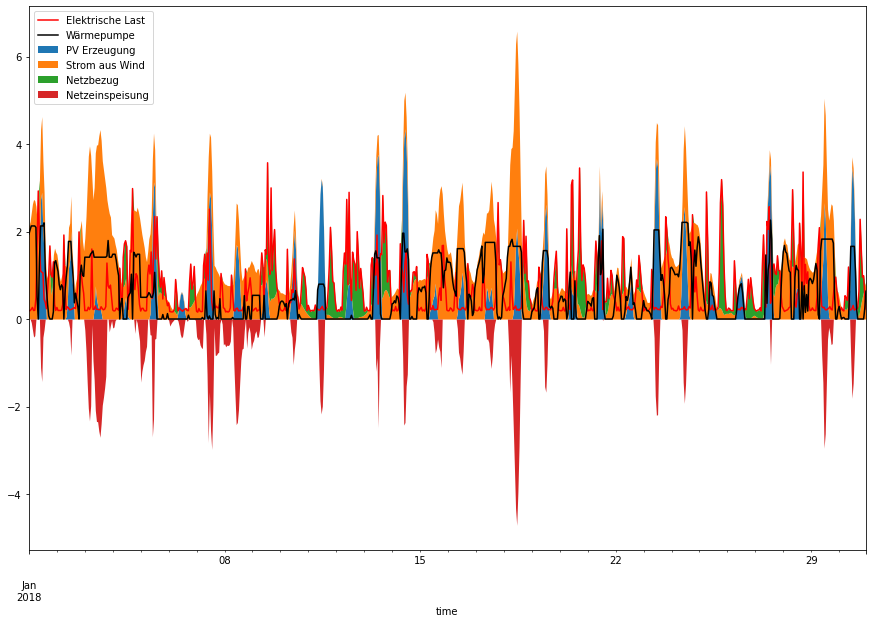

In [86]:
total_load = pd.concat([network_modified_3.loads_t.p_set['electricity_load'], network_modified_3.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['01-01-18 00:00:00':'01-30-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_hp = pd.concat([network_modified_3.generators_t.p['pv'], network_modified_3.generators_t.p['wind'], network_modified_3.generators_t.p['grid_import'], -network_modified_3.generators_t.p['grid_export']], axis = 1)
df_figure_with_hp.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_hp.loc['01-01-18 00:00:00':'01-30-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

# 3.4) Basissystem mit Wärmepumpe, Thermischen Speicher und Batteriespeicher

# Skizze
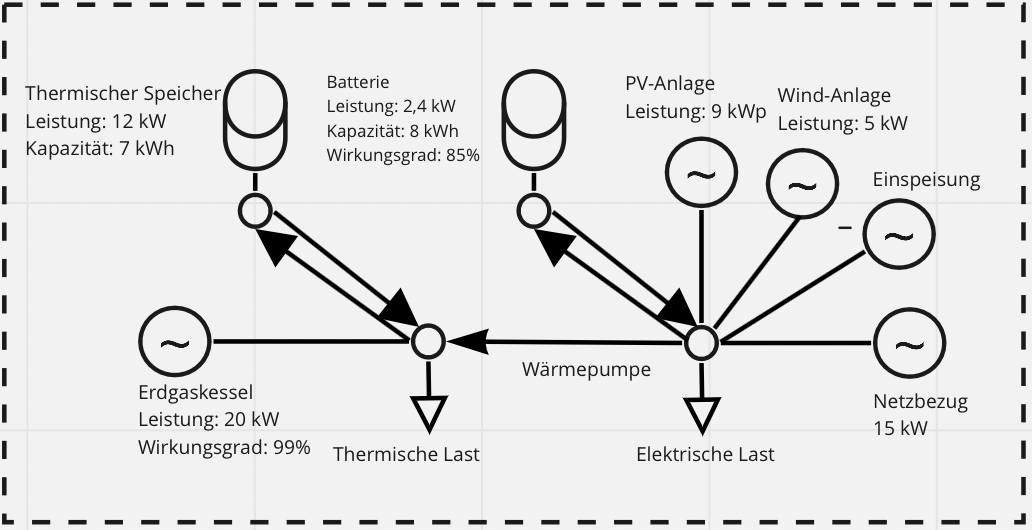

In [74]:
# Basisnetzwerk implementieren:
network_modified_4= pypsa.Network()
network_modified_4.set_snapshots(pv_infeed.index)
network_modified_4.snapshot_weightings = pd.Series(data = 1/1, index = network.snapshots) #Jeder Zeitpunkt repräsentiert 60 Minuten also 1 Stunde.


#Stromknoten definieren
network_modified_4.add("Bus", 
            name = "electricity")

#Wärmeknoten definieren
network_modified_4.add("Bus", 
            name = "thermal")


# Elektrische Last
network_modified_4.add("Load", 
            name ="electricity_load", 
            bus = "electricity", 
            p_set = electrical_load.power_kw)

# Thermische last
network_modified_4.add("Load", 
            name ="thermal_load", 
            bus = "thermal", 
            p_set = thermal_load.power_kw)


#PV-Anlage
network_modified_4.add("Generator", 
            name = "pv",
            bus = "electricity", 
            p_nom = pv["electrical_power"], 
            p_max_pu = pv_infeed.p_max_pu, 
            marginal_cost = 0)

#Wind-Anlage
network_modified_4.add("Generator", 
            name = "wind",
            bus = "electricity", 
            p_nom = wind["electrical_power"], 
            p_max_pu = wind_infeed.p_max_pu, 
            marginal_cost = 0)

#Heizkessel
network_modified_4.add("Generator", 
            name = "boiler", 
            bus = "thermal", 
            p_nom = heating_boiler["thermal_power"], efficiency=heating_boiler["efficiency"], 
            marginal_cost = heating_boiler["gas_costs"]/heating_boiler["efficiency"])


#Netzbezug
network_modified_4.add("Generator", 
            name = "grid_import",
            bus = "electricity", 
            p_nom = grid_import["electrical_power"], 
            marginal_cost = grid_import["electricity_price"])

#Netzeinspeisung
network_modified_4.add("Generator", 
            name = "grid_export",
            bus = "electricity", 
            p_nom = grid_export["electrical_power"], 
            marginal_cost = -grid_export["electricity_revenue"], #Die Kosten müssen hier negativ sein, um Erlöse darzustellen
            sign = -1) #Das Vorzeichen -1 sorgt hier dafür, dass der Generator Leistung aufnimmt und nicht abgibt.

# Hilfsknoten
network_modified_4.add("Bus", 
            name = "storage_electricity")

#Einspeicherleistung vom Knoten "electricity" zum Knoten "storage_electricity"
network_modified_4.add("Link", 
            name = "electrical_storage_charge", 
            bus0 = "electricity", 
            bus1 = "storage_electricity", 
            p_nom = 2.4, # Ladeleistung
            efficiency = math.sqrt(0.85) # Gesamtwirkungsgrad
                    )
#Ausspeicherleistung vom Knoten "storage_electricity" zum Knoten "electricity"
network_modified_4.add("Link", 
            name = "electricity_storage_discharge", 
            bus0 = "storage_electricity", 
            bus1 = "electricity", 
            p_nom = 2.4, #Speicherleistung
            efficiency = math.sqrt(0.85)  # Gesamtwirkungsgrad
                    )
#Speicher
network_modified_4.add("Store", 
            name = "electricity_storage", 
            bus = "storage_electricity", 
            e_nom = 8.0, # Kapazität
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            capital_cost = 900) # annuitätische Kosten

# Hilfsknoten
network_modified_4.add("Bus", 
            name = "storage_thermal")

#Einspeicherleistung vom Knoten "thermal" zum Knoten "storage_thermal"
network_modified_4.add("Link", 
            name = "hot_water_storage_charge", 
            bus0 = "thermal", 
            bus1 = "storage_thermal", 
            p_nom = 12) # 12 kW Einspeicherleistung < Leistung Erdgaskessel

#Ausspeicherleistung vom Knoten "storage_thermal" zum Knoten "thermal"
network_modified_4.add("Link", 
            name = "hot_water_storage_discharge", 
            bus0 = "storage_thermal", 
            bus1 = "thermal", 
            p_nom = 12) # 12 kW Ausspeicherleistung < Leistung Erdgaskessel

#Speicher
network_modified_4.add("Store", 
            name = "hot_water_storage", 
            bus = "storage_thermal", 
            e_nom = 7,
            e_cyclic = True, # Der Speicherfüllstand soll am Ende des Betrachtungszeitraumes wieder den Wert vom Anfang annehmen
            capital_cost = 100   # annuitätische Kosten
            #keine Selbstentladungsverluste   
            )

#Wärmepumpe
#Hier können Sie die Aufgabe mit der Wärmepumpe implementieren. Geben Sie ihrer Wärmepumpe den namen "heat_pump"
network_modified_3.add("Link", 
            name="heat_pump", 
            bus0="electricity", 
            bus1="thermal", 
            p_nom=5.5,
            efficiency = 3.2,
            capital_cost = 7374*0.117  
           )

# Simulation des Basissystems mit Wärmepumpe, thermischer Speicher, Batteriespeicher

In [90]:
# Simulation für den kompletten Zeitraum:
network_modified_4.lopf(solver_name = "glpk", pyomo = False) #Der Parameter pyomo = False hilft uns bei diesem Netzwerk RAM und Rechenzeit zu sparen.

INFO:pypsa.linopf:Prepare linear problem
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:85: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  ext_i = ext_i | n.generators.query('committable').index
/srv/conda/envs/notebook/lib/python3.9/site-packages/pypsa/linopf.py:185: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if not (ext_i & com_i).empty:
INFO:pypsa.linopf:Total preparation time: 1.33s
INFO:pypsa.linopf:Solve linear problem using Glpk solver
INFO:pypsa.linopf:Optimization successful. Objective value: 2.09e+04


('ok', 'optimal')

# Kosten des Basissystems mit Wärmepumpe, thermischen Speicher und Batteriespeicher 

In [91]:
# Ausführung der Auswertungsfunktion
results_modified_4, results_energy_modified_4 = cost_share_evaluation(network_modified_4)
print("Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt "
      + str(round(results_modified_4["Eigenverbrauchsanteil"]*100,2))
      +"%.\n Dabei entstehen Stromkosten von "
      +str(round(results_modified_4["Stromkosten"]/100,2))
      +"€, Gaskosten von "
      +str(round(results_modified_4["Gaskosten"]/100,2))
      +"€ und EEG-Erlöse von "
      +str(round(results_modified_4["Stromerlöse"]/100,2))
      +", wobei " +str(round(results_with_modification["Nicht nutzbare Energie"]/100,1))
      + "kWh PV-Strom abgeregelt werden müssen.\n"
      +" Die Gesamtkosten betragen "+ str(round(results_with_modification["Gesamtkosten"]/100,2)) 
      +"€.\n"
      +"Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um "
      +str(round((results_modified_4["Eigenverbrauchsanteil"]- results_base["Eigenverbrauchsanteil"])*100,2))
      +" Prozentpunkte und eine Verringerung der Kosten um "
      +str(round((results_base["Gesamtkosten"]-results_modified_4["Gesamtkosten"])/100,2))
      +"€."
     )

Der Eigenverbrauchsanteil am Stromverbrauch in der erweiterten Konfiguration beträgt 97.73%.
 Dabei entstehen Stromkosten von 66.76€, Gaskosten von 874.08€ und EEG-Erlöse von 731.52, wobei 0.0kWh PV-Strom abgeregelt werden müssen.
 Die Gesamtkosten betragen 209.32€.
Gegenüber der Basiskonfiguration ist dies eine Erhöhung des Eigenverbrauchsanteils um 28.76 Prozentpunkte und eine Verringerung der Kosten um 685.07€.


# Visualisierung des Basissystems mit Wärmepumpe, thermischen Speicher und Batteriespeicher 

<AxesSubplot:xlabel='time'>

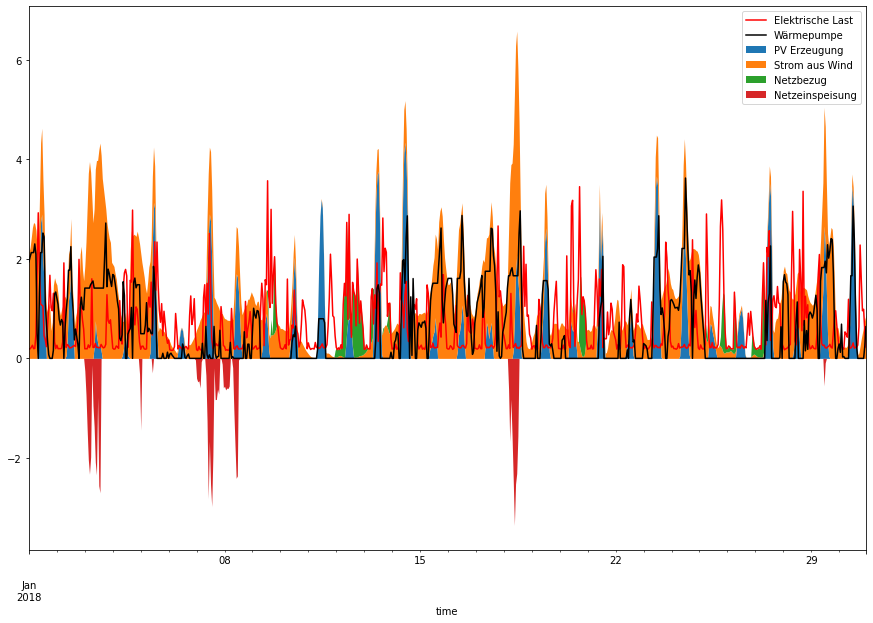

In [92]:
total_load = pd.concat([network_modified_4.loads_t.p_set['electricity_load'], network_modified_4.links_t.p0['heat_pump']], axis = 1)
total_load.columns = ['Elektrische Last', 'Wärmepumpe']
ax = total_load.loc['01-01-18 00:00:00':'01-30-18 23:00:00'].plot(color = ['red', 'black'], legend = True, stacked = False)
df_figure_with_hp = pd.concat([network_modified_4.generators_t.p['pv'], network_modified_4.generators_t.p['wind'], network_modified_4.generators_t.p['grid_import'], -network_modified_4.generators_t.p['grid_export']], axis = 1)
df_figure_with_hp.columns = ['PV Erzeugung', 'Strom aus Wind', 'Netzbezug', 'Netzeinspeisung']
df_figure_with_hp.loc['01-01-18 00:00:00':'01-30-18 23:00:00'].plot(subplots = False, figsize=(15,10), kind= 'area', linewidth=0, ax = ax)

# 4) Interpretation

de

# 5)  Vergleich der einzlenen Komponenten auf die Elektrizitätsbilanz  

In [93]:
energy_figure = pd.DataFrame([results_energy_base, results_energy_modified, results_energy_modified_2, results_energy_with_modification, results_energy_modified_4], index = ['Basis', 'Batteriespeicher','Thermischer Speicher','Wärmepumpe','alle Modifikationen'])

<AxesSubplot:title={'center':'Elektrizitätsbilanz in kWh'}>

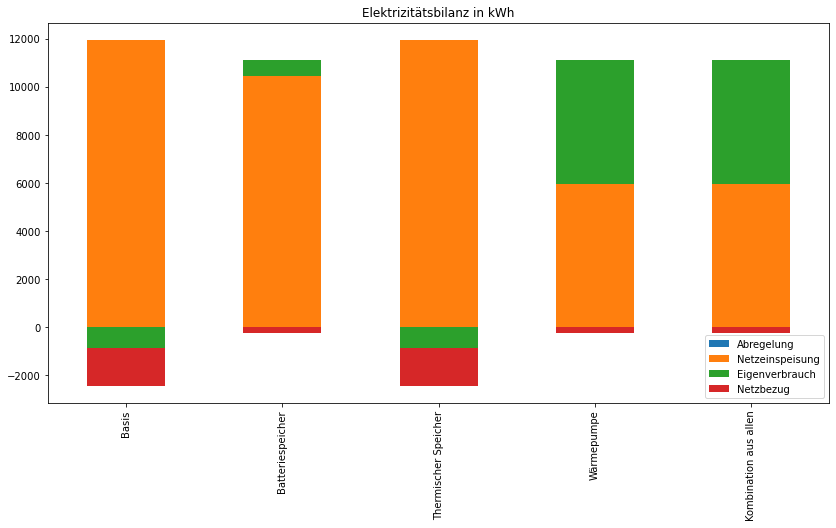

In [94]:
energy_figure.plot(kind='bar', stacked = True, figsize=(14,7), title = 'Elektrizitätsbilanz in kWh')